# Lab 2b: Model selection
## Dark matter
We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). The task is to classifying gamma rays, which consist of high-energy particles. When they hit our atmosphere, they produce chain reactions of other particles called 'showers'. However, similar showers are also produced by other particles (hadrons). We want to be able to detect which ones originate from gamma rays and which ones come from background radiation. To do this, the observed shower patterns are observed and converted into 10 numeric features. You need to detect whether these are gamma rays or background radiation. This is a key aspect of research into dark matter, which is believed to generate such gamma rays. If we can detect where they occur, we can build a map of the origins of gamma radiation, and locate where dark matter may occur in the observed universe. However, we'll first need to accurately detect these gamma rays first.

A quick visualization of the features is shown below. Note that this is not a time series, we just plot the instances in the order they occur in the dataset. The first 12500 or so are examples of signal (gamma), the final 6700 or so are background (hadrons).

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

In [2]:
# Download MAGIC Telescope data from OpenML. You can repeat this analysis with any other OpenML classification dataset.
magic = oml.datasets.get_dataset(1120)
X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array'); 
attribute_names = [f.name for i,f in magic.features.items()][:-1][1:]

C:\Users\Lucas-PC\AppData\Local\Temp\ipykernel_19196\2616928666.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  magic = oml.datasets.get_dataset(1120)
C:\Users\Lucas-PC\AppData\Local\Temp\ipykernel_19196\2616928666.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array');


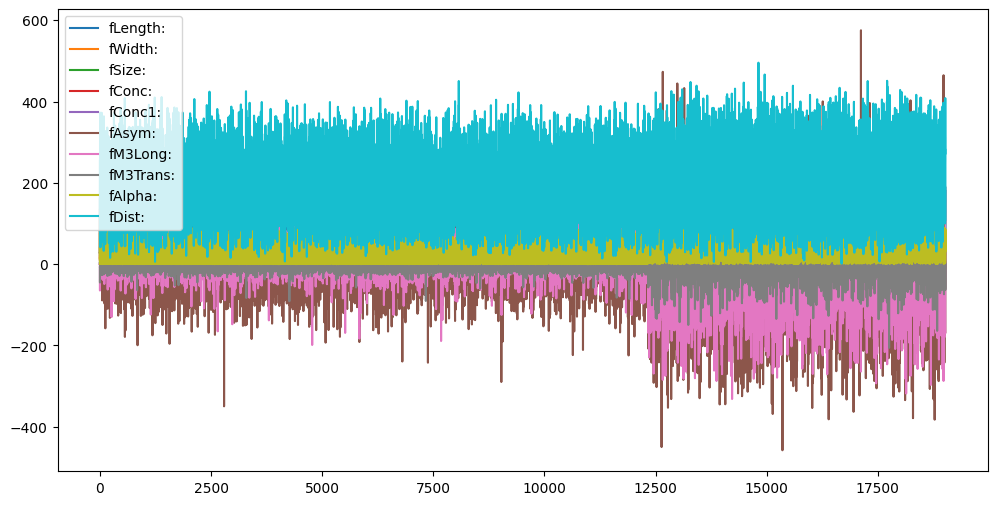

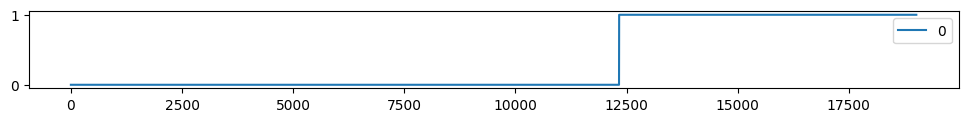

In [3]:
# Quick visualization of the features (top) and the target (bottom)
magic_df = pd.DataFrame(X, columns=attribute_names)
magic_df.plot(figsize=(12,6))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(y).plot(figsize=(12,1));

## Exercise 1: Metrics
Train and evaluate an SVM with RBF kernel (default hyperparameters) using a standard 25% holdout. Report the accuracy, precision, recall, F1 score, and area under the ROC curve (AUC).

Answer the following questions:
* How many of the detected gamma rays are actually real gamma rays?
* How many of all the gamma rays are we detecting?
* How many false positives and false negatives occur?

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=0, stratify=y, train_size=0.25)
model = SVC(kernel="rbf", probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8140904311251315
Precision: 0.8608058608058609
Recall: 0.562200956937799
F1: 0.6801736613603473
AUC: 0.7564491648133692
Confusion matrix:
[[8793  456]
 [2196 2820]]


86% of detected rays are actually rays (precision),
56% of all rays are detected (recall)
nearly 2200 false negatives occur and 456 false positives

## Exercise 2: Preprocessing
SVMs require scaling to perform well. For now, use the following code to scale the data (we'll get back to this in the lab about preprocessing and pipelines). Repeat question 2 on the scaled data. Have the results improved? 

In [5]:
from sklearn.preprocessing import StandardScaler
# Important here is to fit the scaler on the training data alone
# Then, use it to scale both the training set and test set
# This assumes that you named your training set X_train. Adapt if needed.
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

In [6]:
model = SVC(kernel="rbf", probability=True)
model.fit(Xs_train, y_train)
ys_pred = model.predict(Xs_test)
print('Accuracy:', accuracy_score(y_test, ys_pred))
print('Precision:', precision_score(y_test, ys_pred))
print('Recall:', recall_score(y_test, ys_pred))
print('F1:', f1_score(y_test, ys_pred))
print('AUC:', roc_auc_score(y_test, ys_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, ys_pred))

Accuracy: 0.8614791447599018
Precision: 0.889543823680164
Recall: 0.6919856459330144
F1: 0.7784256559766763
AUC: 0.8226930067701616
Confusion matrix:
[[8818  431]
 [1545 3471]]


Results have slightly improved

## Exercise 3: Hyperparameter optimization
Use 50 iterations of random search to tune the $C$ and $gamma$ hyperparameters on the scaled training data. Vary both on a log scale (e.g. from 2^-12 to 2^12). Optimize on AUC and use 3 cross-validation (CV) folds for the inner CV to estimate performance. For the outer loop, just use the train-test split you used before (hence, no nested CV). Report the best hyperparameters and the corresponding AUC score. Is it better than the default? Finally, use them to evaluate the model on the held-out test set, for all 5 metrics we used before.

Extra challenge: plot the samples used by the random search ($C$ vs $gamma$)

Note: The reason we don't use a nested CV just yet is because we would need to rebuild the scaled training and test set multiple times. This is tedious, unless we use pipelines, which we'll cover in a future lab.

Fitting 3 folds for each of 25 candidates, totalling 75 fits


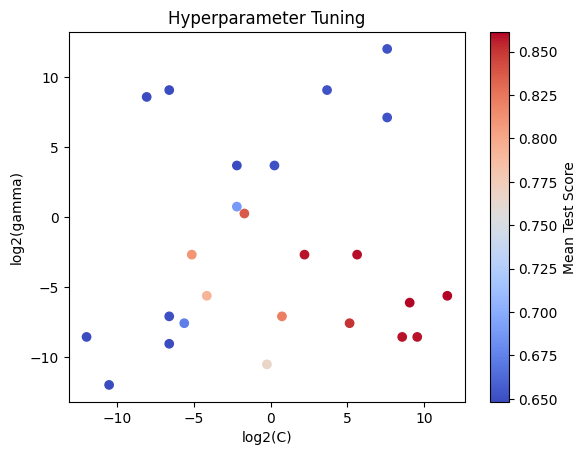

In [14]:
# sklearn random search
from sklearn.model_selection import RandomizedSearchCV
grid = {"C": np.logspace(-12, 12, base=2), "gamma": np.logspace(-12, 12, base=2)}
random_search = RandomizedSearchCV(SVC(), param_distributions=grid, n_iter=25, cv=3, n_jobs=-1, verbose=2)
random_search.fit(Xs_train, y_train)
# Plot the training score for each hyperparameter combination in a scatter plot
scores = random_search.cv_results_['mean_test_score']
C = random_search.cv_results_['param_C'].data
gamma = random_search.cv_results_['param_gamma'].data

plt.scatter(np.log2(C.astype(float)), np.log2(gamma.astype(float)), c=scores, cmap=cm.coolwarm)
plt.xlabel('log2(C)')
plt.ylabel('log2(gamma)')
plt.colorbar(label='Mean Test Score')
plt.title('Hyperparameter Tuning')
plt.show()


In [15]:
print("Best score: {:.4f}",random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)

Best score: {:.4f} 0.861198738170347
Best hyperparameters: {'gamma': 0.020155912920295584, 'C': 2916.8673874012834}


In [16]:
print("Default gamma: ",model._gamma)
print("Default C: ",model.C)

Default gamma:  0.10000000045045411
Default C:  1.0


In [17]:
# Get best estimator, train on the full training set, and evaluate on the test set
best_svm = random_search.best_estimator_.fit(Xs_train,y_train)
y_pred = best_svm.predict(Xs_test)

# Get the scores by comparing the predictions y_pred with the ground truth y_test
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

Accuracy: 0.869
Precision: 0.892
Recall: 0.713
F1 score: 0.793
AUC: 0.833


## Exercise 4: Threshold calibration
First, plot the Precision-Recall curve for the SVM using the default parameters on the scaled data. Then, calibrate the threshold to find a solution that yields better recall without sacrificing too much precision.

Text(0, 0.5, 'Precision')

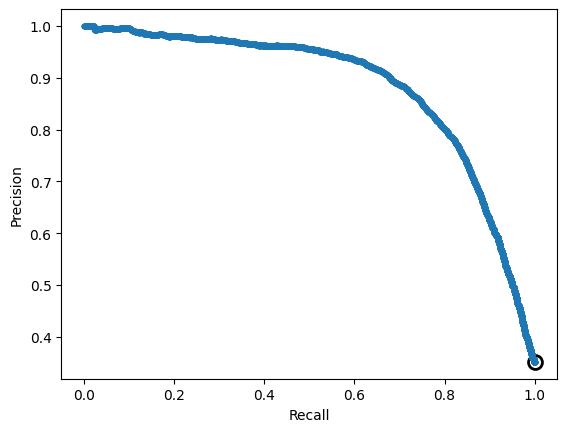

In [18]:
# Use precesion recall curve from sklearn
# TODO understand solution better
from sklearn.metrics import precision_recall_curve
p_pred = model.predict_proba(Xs_test)[:,1] # Should use the decision function?
precision, recall, thresholds = precision_recall_curve(y_test, p_pred)
close_zero = np.argmin(np.abs(thresholds))
plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')

Text(0, 0.5, 'Precision')

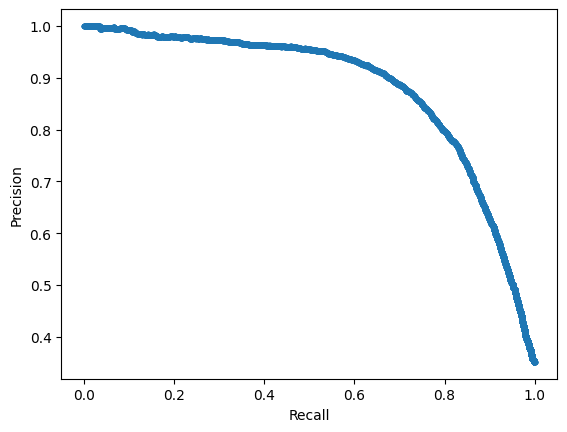

In [8]:
from sklearn.calibration import CalibratedClassifierCV

# Calibrate SVC model
calibrated_model = CalibratedClassifierCV(model)
calibrated_model.fit(Xs_train, y_train)
calibrated_y_pred = calibrated_model.predict(Xs_test)
calibrated_p_pred = calibrated_model.predict_proba(Xs_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, calibrated_p_pred)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision') 

## Exercise 5: Cost function
Assume that a false negative is twice as bad (costly) than a false positive. I.e. we would rather waste time checking gamma ray sources that are not real, than missing an interesting gamma ray source. Use ROC analysis to find the optimal threshold under this assumption.

Finally, let the model make predictions using the optimal threshold and report all 5 scores. Is recall better now? Did we lose a lot of precision?

Text(0, 0.5, 'True Positive Rate')

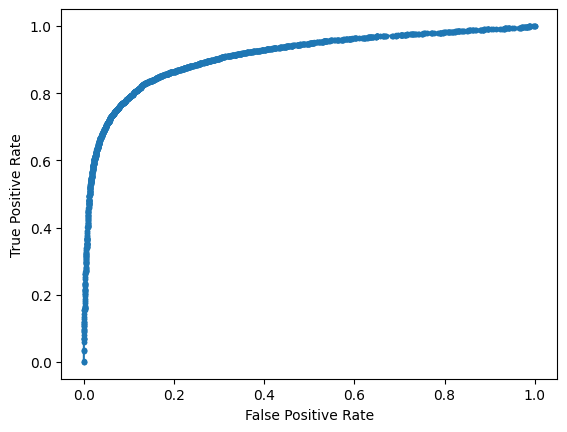

In [9]:
# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, calibrated_p_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')